# An end-to-end example of interpolation using raster files and scanlines 

In [1]:
import pandas as pd
import pickle
import geopandas as gpd
import numpy as np

from tobler.scanlines_raster_interpolation import scanline_harmonization
from shapely.ops import cascaded_union
from shapely.geometry import Polygon

In [2]:
help(scanline_harmonization)

Help on function scanline_harmonization in module tobler.scanlines_raster_interpolation:

scanline_harmonization(source_gdf, target_gdf, pop_string, raster_path, auxiliary_type='nlcd', regression_method='Poisson', codes=[21, 22, 23, 24], n_pixels_option_values=256, ReLU=True, **kwargs)
    Function that generates an interpolated population using scanlines with the entire pipeline.
    
    Parameters
    ----------
    
    source_gdf             : geopandas GeoDataFrame with geometry column of polygon type for the source set of polygons desired.
    
    target_gdf             : geopandas GeoDataFrame with geometry column of polygon type for the target set of polygons desired.
    
    pop_string             : the name of the variable on geodataframe that the interpolation shall be conducted.
    
    raster_path            : the path to the associated raster image.
    
    auxiliary_type         : string. The type of the auxiliary variable for the desired method of interpolation. De

First, let's define the path to the raster and to the data:

In [3]:
raster_path = 'C:\\Users\\renan\\Desktop\\scan_line_JAVA\\NLCD2011_LC_Pennsylvania.tif'
filepath = 'C:\\Users\\renan\\Desktop\\full_count_2010\\std_2010_fullcount.csv'

In [4]:
census_2010 = pd.read_csv(filepath, encoding = "ISO-8859-1", sep = ",")

# This file can be download here: https://drive.google.com/open?id=1gWF0OCn6xuR_WrEj7Ot2jY6KI2t6taIm
with open('tracts_US.pkl', 'rb') as input:
    map_gpd = pickle.load(input)

df = census_2010.loc[(census_2010.state == "PA")]

map_gpd['INTGEOID10'] = pd.to_numeric(map_gpd["GEOID10"])
merged_gdf = map_gpd.merge(df, left_on = 'INTGEOID10', right_on = 'trtid10')
merged_gdf.head()

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,COUNTY_ID,county_id2,COUNTYNS10,NAME10_COU,GEOID_MSA,...,a15hsp10,a60hsp10,ageasn10,a15asn10,a60asn10,agentv10,a15ntv10,a60ntv10,globd10,globg10
0,42,001,030800,42001030800,308,42001,42001,1213656,Adams,23900,...,132,14,60,14,5,6,1,2,w,White
1,42,001,030400,42001030400,304,42001,42001,1213656,Adams,23900,...,164,24,23,7,0,11,1,2,wh,Single immig
2,42,001,030300,42001030300,303,42001,42001,1213656,Adams,23900,...,204,15,11,4,1,15,5,2,wh,Single immig
3,42,001,030500,42001030500,305,42001,42001,1213656,Adams,23900,...,155,18,8,1,2,4,0,2,wh,Single immig
4,42,001,030700,42001030700,307,42001,42001,1213656,Adams,23900,...,167,19,42,6,7,3,0,1,w,White


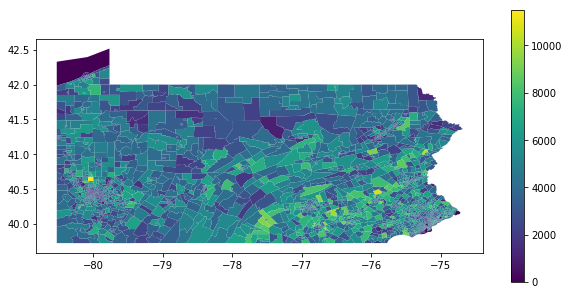

In [5]:
%matplotlib inline
merged_gdf.plot(column = 'pop10', legend = True, figsize = (10, 5))

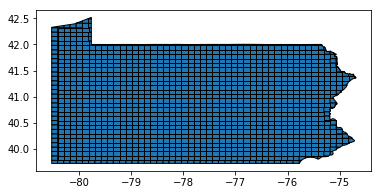

In [6]:
# Building entire region of Pennsylvania

boundary = gpd.GeoSeries(cascaded_union(merged_gdf.geometry)).buffer(0.001) # The 'buffer' method prevents some unusual points inside the state
pa_region_pre = gpd.GeoDataFrame(gpd.GeoSeries(boundary))
pa_region = pa_region_pre.rename(columns={0:'geometry'}).set_geometry('geometry')

# Building a lattice of region of Pennsylvania

low_left  = -81
low_right = -74
up_left = 38
up_right = 43

thickness = 60

# This snippet was inspired in https://github.com/pysal/libpysal/blob/aa7882e7877b962f4269ea86a612dfc58152e5c6/libpysal/weights/user.py#L95
aux = list()
for i in np.linspace(low_left, low_right, num = thickness):
        for j in np.linspace(up_left, up_right, num = thickness):
            
            # Each width 'jump' must be at the same order of the grid constructed
            ll = i, j
            ul = i, j + np.diff(np.linspace(up_left, up_right, num = thickness))[0]
            ur = i + np.diff(np.linspace(low_left, low_right, num = thickness))[0], j + np.diff(np.linspace(up_left, up_right, num = thickness))[0]
            lr = i + np.diff(np.linspace(low_left, low_right, num = thickness))[0], j
            aux.append(Polygon([ll, ul, ur, lr, ll]))
            
polys2 = gpd.GeoSeries(aux)

envgdf = gpd.GeoDataFrame(polys2)
envgdf_final = envgdf.rename(columns={0:'geometry'}).set_geometry('geometry')

# Overlapping both regions

res_union = gpd.overlay(pa_region, envgdf_final, how='intersection')
res_union.plot(edgecolor = 'black')

In [7]:
res_union.crs = merged_gdf.crs
res_union.crs

{'init': 'epsg:4326'}

# Ok... now it is time to perform the interpolation:

## Poisson likelihood

In [8]:
end_to_end_poisson = scanline_harmonization(merged_gdf, res_union, 'pop10', raster_path)

INITIALIZING FIRST SCANLINES
Opening raster metadata...
Matching both crs's (reprojecting source_gdf to raster)...
Starting to create well-known text (wkt) of geometries...
Starting to convert the GeoDataFrame to a temporary file...
Time of preparation before scanline (in seconds): 1.0579216480255127
Starting to perform the scanline...
Scanline: Done.
Time of scanline itself (in seconds): 19.526257514953613

INITIALIZING SECOND SCANLINES
Opening raster metadata...
Matching both crs's (reprojecting source_CTs to raster)...
...reprojecting target_gdf to raster)...
Starting to create well-known text (wkt) of geometries...
Starting to convert the GeoDataFrame to a temporary file...
Source CT: Starting to create well-known text (wkt) of geometries...
Starting to convert the GeoDataFrame to a temporary file...
Time of preparation before scanline (in seconds): 1.1449615955352783
Starting to perform the scanline...
Scanline: Done.
Time of scanline itself (in seconds): 11.733731269836426


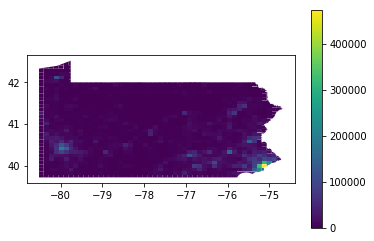

In [9]:
end_to_end_poisson.plot(column = 'Attribute', legend = True)

## Gaussian likelihood

In [10]:
end_to_end_gaussian = scanline_harmonization(merged_gdf, res_union, 'pop10', raster_path, regression_method = "Gaussian")

INITIALIZING FIRST SCANLINES
Opening raster metadata...
Matching both crs's (reprojecting source_gdf to raster)...
Starting to create well-known text (wkt) of geometries...
Starting to convert the GeoDataFrame to a temporary file...
Time of preparation before scanline (in seconds): 0.9782052040100098
Starting to perform the scanline...
Scanline: Done.
Time of scanline itself (in seconds): 19.855607509613037

INITIALIZING SECOND SCANLINES
Opening raster metadata...
Matching both crs's (reprojecting source_CTs to raster)...
...reprojecting target_gdf to raster)...
Starting to create well-known text (wkt) of geometries...
Starting to convert the GeoDataFrame to a temporary file...
Source CT: Starting to create well-known text (wkt) of geometries...
Starting to convert the GeoDataFrame to a temporary file...
Time of preparation before scanline (in seconds): 1.1472630500793457
Starting to perform the scanline...
Scanline: Done.
Time of scanline itself (in seconds): 14.432897806167603


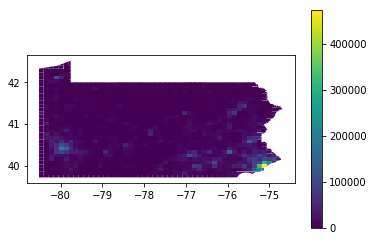

In [11]:
end_to_end_gaussian.plot(column = 'Attribute', legend = True)

### Comparing both likelihoods

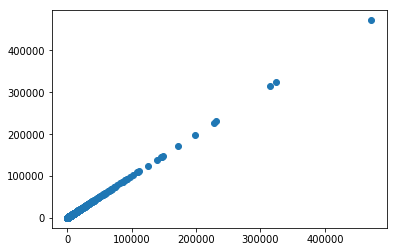

In [12]:
import matplotlib.pyplot as plt
plt.scatter(end_to_end_poisson['Attribute'], end_to_end_gaussian['Attribute'])